In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
import torch
import torch.nn as nn
from torch.autograd import Variable

c:\Users\David\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


El dataset con el que se trabajará en esta ocasión serán datos historicos de acciones (stock proces) de la empresa Apple (AAPL) usando la librería "yfinance"; estos datos se guardaran en un archivo CSV

El resultado de la data:

* Open: precio de apertura.
* High: precio máximo del día.
* Low: precio mínimo.
* Close: precio de cierre.
* Adj Close: precio ajustado (considerando dividendos o splits).
* Volume: número de acciones negociadas ese día.


🧠 En resumen:

El código descarga automáticamente 15 años de datos históricos de las acciones de Apple, muestra una vista previa, y guarda los datos en un CSV. Es un paso típico en proyectos de análisis financiero, machine learning o pronóstico de precios

In [2]:
# Descargar datos de AAPL (ajusta fechas si es necesario)
ticker = 'AAPL'   # Símbolo de Apple Inc., (puede ser de la accion que se quiere descargar) en la bolsa de valores de NASDAQ (otra empresa, por ejemplo Microsoft, usarías 'MSFT')
start_date = '2010-01-01' # inicio de fecha de los datos
end_date = datetime.now().strftime('%Y-%m-%d')  # Fecha actual

data = yf.download(ticker, start=start_date, end=end_date)  # yf.download: es la funcion del paquete yfinance para descargar los datos historicos de los precios de las acciones de Yahoo Finance
print(data.head())  # Ver primeros registros

# Guardar en CSV para referencia
data.to_csv('C:/Users/David/Documents/Perfil Upwork/Predicción de Series Temporales para Precios de Acciones (ML Avanzado)/aapl_data.csv')

print(data.columns)  # Verificar columnas: ['Open', 'High', 'Low', 'Close', 'Volume']

C:\Users\David\AppData\Local\Temp\ipykernel_18696\1371299569.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)  # yf.download: es la funcion del paquete yfinance para descargar los datos historicos de los precios de las acciones de Yahoo Finance
[*********************100%***********************]  1 of 1 completed

Price          Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                         
2010-01-04  6.424605  6.439315  6.375673  6.407194  493729600
2010-01-05  6.435713  6.472038  6.401790  6.442318  601904800
2010-01-06  6.333344  6.461230  6.326739  6.435713  552160000
2010-01-07  6.321636  6.364265  6.275706  6.356760  477131200
2010-01-08  6.363663  6.364264  6.276005  6.313229  447610800
MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


# Limpieza de los datos

In [3]:

# === CARGA Y LIMPIEZA INICIAL ===
data = pd.read_csv(
    'C:/Users/David/Documents/Perfil Upwork/Predicción de Series Temporales para Precios de Acciones (ML Avanzado)/aapl_data.csv',
    skiprows=[1],      # salta la fila con los tickers ("AAPL")
)

# Renombrar la primera columna a 'Date' si no se llama así
if data.columns[0].lower() != 'date':
    data.rename(columns={data.columns[0]: 'Date'}, inplace=True)

# Convertir la columna 'Date' a tipo datetime
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')

# Establecer 'Date' como índice del DataFrame
data = data.set_index('Date')

print("✅ Primeras filas del DataFrame:")
print(data.head())

# === DIAGNÓSTICO DE TIPOS ===
print("\nTipos de datos:")
print(data.dtypes)

# === ASEGURAR QUE 'Close' SEA NUMÉRICA ===
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Verificar valores no numéricos
print("\nValores NaN en 'Close' tras conversión:")
print(data['Close'].isna().sum())

# Eliminar filas donde 'Close' esté vacía
data = data.dropna(subset=['Close'])

# === TRABAJO CON SERIES TEMPORALES ===
ts_data = data['Close']

# Confirmar que el índice es tipo datetime
ts_data.index = pd.to_datetime(ts_data.index, errors='coerce')

# --- Detección de outliers con IQR ---
Q1 = ts_data.quantile(0.25)
Q3 = ts_data.quantile(0.75)
IQR = Q3 - Q1
ts_data = ts_data[~((ts_data < (Q1 - 1.5 * IQR)) | (ts_data > (Q3 + 1.5 * IQR)))]

# --- Resample a diario (relleno hacia adelante) ---
ts_data = ts_data.resample('D').ffill()

# --- Estadísticas ---
print("\n📊 Estadísticas básicas de 'Close' tras limpieza:")
print(ts_data.describe())

✅ Primeras filas del DataFrame:
               Close      High       Low      Open       Volume
Date                                                           
NaT              NaN       NaN       NaN       NaN          NaN
2010-01-04  6.424605  6.439315  6.375673  6.407194  493729600.0
2010-01-05  6.435713  6.472038  6.401790  6.442318  601904800.0
2010-01-06  6.333344  6.461230  6.326739  6.435713  552160000.0
2010-01-07  6.321636  6.364265  6.275706  6.356760  477131200.0

Tipos de datos:
Close     float64
High      float64
Low       float64
Open      float64
Volume    float64
dtype: object

Valores NaN en 'Close' tras conversión:
1

📊 Estadísticas básicas de 'Close' tras limpieza:
count    5769.000000
mean       75.224175
std        72.363877
min         5.765364
25%        18.127052
50%        37.573547
75%       140.547806
max       262.239990
Name: Close, dtype: float64


C:\Users\David\AppData\Local\Temp\ipykernel_18696\455899062.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'], errors='coerce')


# Análisis de estacionariedad


Resultados de la prueba ADF: (np.float64(1.1210000984910737), np.float64(0.9953919243268985), 33, 5735)
Valor p-vlor de la prueba ADF: 0.9953919243268985

Resultados de la prueba ADF en la serie diferenciada: (np.float64(-12.904326111188118), np.float64(4.183841980504675e-24), 32, 5735)
Valor p-valor de la prueba ADF en la serie diferenciada: 4.183841980504675e-24


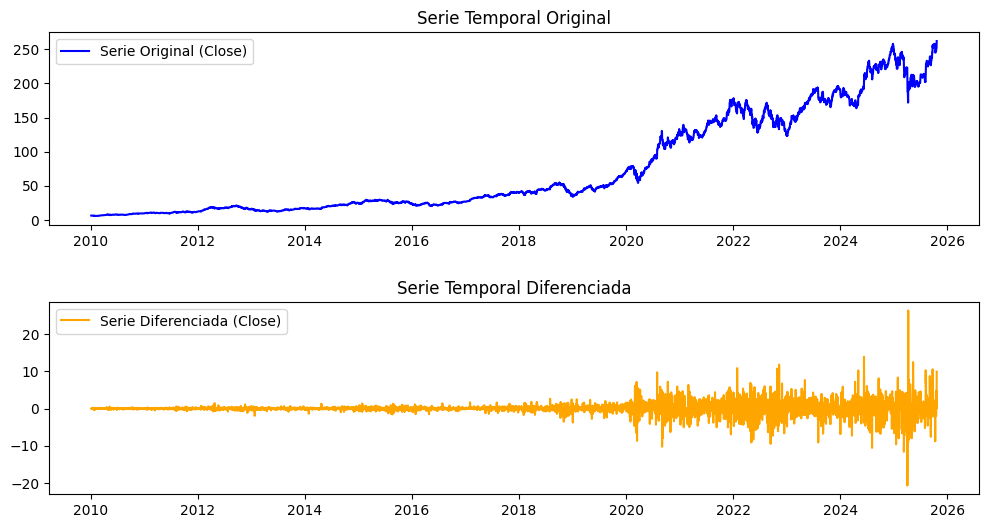

In [4]:
result = adfuller(ts_data)
print('\nResultados de la prueba ADF:', result[0:4])  # Estadístico de prueba, p-valor, número de retardos usados, número de observaciones usadas
print('Valor p-vlor de la prueba ADF:', result[1])
# si el p-valor es menor a 0.05, se rechaza la hipótesis nula de que la serie tiene una raíz unitaria (es no estacionaria)  y se concluye que la serie es estacionaria. 
# Si el p-valor es mayor a 0.05, no se puede rechazar la hipótesis nula y se concluye que la serie es no estacionaria.  

# diferenciación para hacer la serie estacionaria si es necesario
ts_diff = ts_data.diff().dropna() # primera diferenciación

# Prueba ADF en la serie diferenciada
result_diff = adfuller(ts_diff)
print('\nResultados de la prueba ADF en la serie diferenciada:', result_diff[0:4])  # Estadístico de prueba, p-valor, número de retardos usados, número de observaciones usadas
print('Valor p-valor de la prueba ADF en la serie diferenciada:', result_diff[1])

# gráfico de la visualización de la serie temporal original y diferenciada
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(ts_data, label='Serie Original (Close)', color='blue')
plt.title('Serie Temporal Original')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(ts_diff, label='Serie Diferenciada (Close)', color='orange')  
plt.title('Serie Temporal Diferenciada')
plt.legend()
plt.subplots_adjust(hspace=0.4)  # ✅ Correcto
plt.show()


# Feature Lagging (para LSTM)

In [5]:
# Crear lags para LSTM (usar los últimos 60 días para predecir el siguiente día)
def create_lagged_features(series, lag_days=60):
    X, y = [], []
    for i in range(lag_days, len(series)):
        X.append(series[i-lag_days:i])
        y.append(series[i])
    return np.array(X), np.array(y)

# Normalizar los datos (LSTM sensible a escalas)
scaler = MinMaxScaler()
ts_scaled = scaler.fit_transform(ts_data.values.reshape(-1, 1))

X, y = create_lagged_features(ts_scaled.flatten())
X = X.reshape((X.shape[0], X.shape[1], 1))  # Reshape para LSTM: (samples, timesteps, features)

# Split en entrenamiento y prueba (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Modelado y Predicción

Implementamos ARIMA, Prophet y LSTM, ajustados para usar Close.

## a. ARIMA

In [6]:
# Ajustar ARIMA (p,d,q) - ejemplo (1,1,1), ajusta según ACF/PACF si deseas
model_arima = ARIMA(ts_data, order=(1,1,1))
arima_fit = model_arima.fit()

# Predicción (próximos 30 días)
forecast_arima = arima_fit.forecast(steps=30)

# Predicción en test (para comparación)
pred_arima = arima_fit.predict(start=len(ts_data)-len(y_test), end=len(ts_data)-1)

## b. Prophet

In [7]:
# Preparar datos para Prophet
df_prophet = pd.DataFrame({'ds': ts_data.index, 'y': ts_data.values})

# Ajustar modelo
model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(df_prophet)

# Predicción
future = model_prophet.make_future_dataframe(periods=30)
forecast_prophet = model_prophet.predict(future)

# Predicciones vs reales (últimos len(y_test))
pred_prophet = forecast_prophet['yhat'][-len(y_test)-30:-30]

20:57:43 - cmdstanpy - INFO - Chain [1] start processing
20:57:45 - cmdstanpy - INFO - Chain [1] done processing


## c. LSTM (con PyTorch)

In [8]:
# ======================================
# 1️⃣ Definir el modelo LSTM
# ======================================
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Solo la última salida
        return out


# ======================================
# 2️⃣ Instanciar modelo y definir pérdida + optimizador
# ======================================
model_lstm = LSTMModel(input_size=1, hidden_size=32)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)


# ======================================
# 3️⃣ Convertir datos a tensores con la forma correcta
# (batch_size, seq_length, input_size)
# ======================================
X_train_t = torch.FloatTensor(X_train).view(X_train.shape[0], X_train.shape[1], 1)
y_train_t = torch.FloatTensor(y_train).view(-1, 1)
X_test_t  = torch.FloatTensor(X_test).view(X_test.shape[0], X_test.shape[1], 1)


# ======================================
# 4️⃣ Entrenamiento por mini-batches
# ======================================
batch_size = 32
epochs = 50

for epoch in range(epochs):
    total_loss = 0.0
    for i in range(0, len(X_train_t), batch_size):
        batch_X = X_train_t[i:i + batch_size]
        batch_y = y_train_t[i:i + batch_size]

        outputs = model_lstm(batch_X)
        loss = criterion(outputs, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Época [{epoch+1}/{epochs}] - Pérdida promedio: {total_loss/len(X_train_t):.6f}")


# ======================================
# 5️⃣ Predicción en test
# ======================================
with torch.no_grad():
    pred_lstm_scaled = model_lstm(X_test_t).numpy()
    pred_lstm = scaler.inverse_transform(pred_lstm_scaled)


# ======================================
# 6️⃣ Predicción futura (30 días)
# ======================================
last_input = torch.FloatTensor(X[-1].reshape(1, -1, 1))
future_preds = []

for _ in range(30):
    with torch.no_grad():
        next_pred = model_lstm(last_input).numpy()

    # Agregar la predicción y actualizar la ventana
    future_preds.append(next_pred[0][0])
    last_input = torch.cat(
        (last_input[:, 1:, :], torch.FloatTensor(next_pred).reshape(1, 1, 1)),
        dim=1
    )

future_lstm = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

print("\n✅ Entrenamiento completado y predicciones futuras generadas correctamente.")


Época [10/50] - Pérdida promedio: 0.000004
Época [20/50] - Pérdida promedio: 0.000002
Época [30/50] - Pérdida promedio: 0.000008
Época [40/50] - Pérdida promedio: 0.000006
Época [50/50] - Pérdida promedio: 0.000004

✅ Entrenamiento completado y predicciones futuras generadas correctamente.


# Gráficos de Predicciones vs. Reales

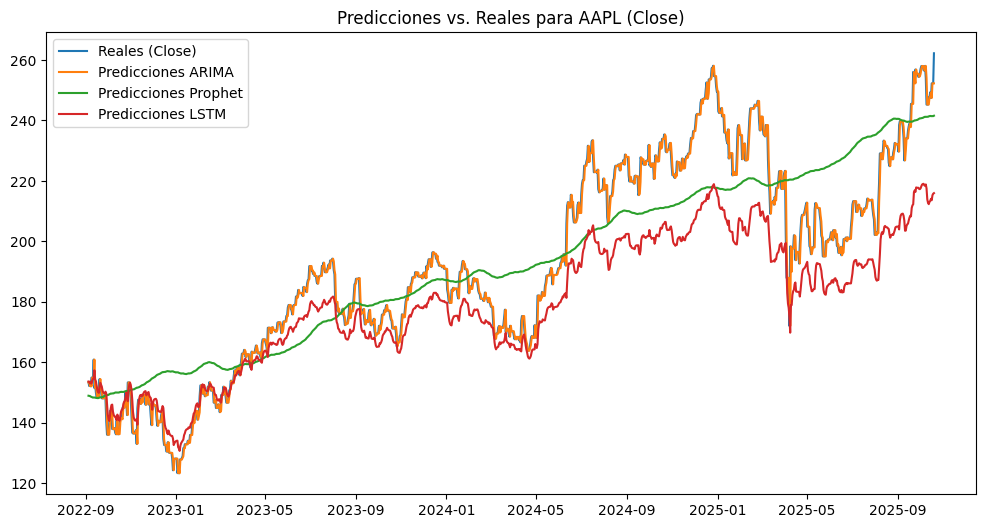

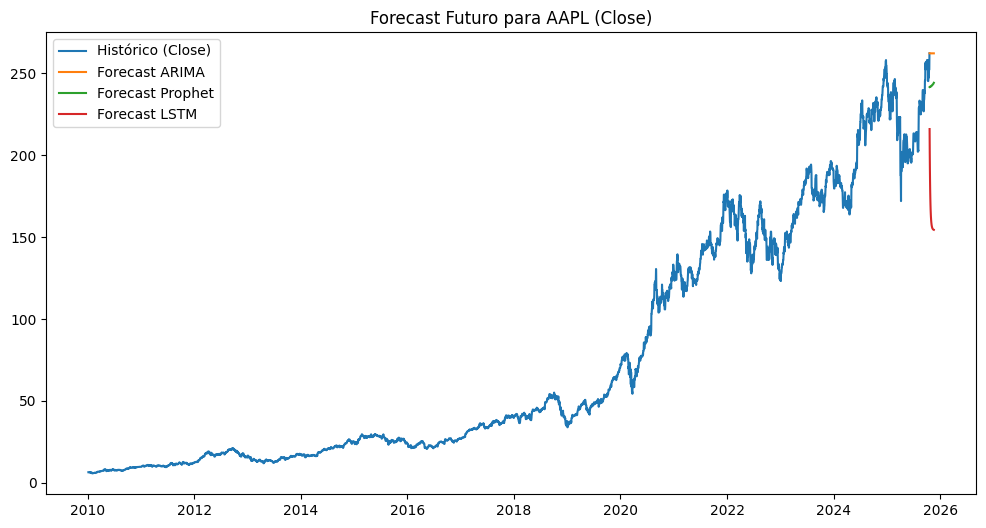

In [26]:
# Fechas para test
test_dates = ts_data.index[-len(y_test):]

# Gráfico comparativo
plt.figure(figsize=(12,6))
plt.plot(test_dates, scaler.inverse_transform(y_test.reshape(-1, 1)), label='Reales (Close)')
plt.plot(test_dates, pred_arima, label='Predicciones ARIMA')
plt.plot(test_dates, pred_prophet, label='Predicciones Prophet')
plt.plot(test_dates, pred_lstm, label='Predicciones LSTM')
plt.legend()
plt.title('Predicciones vs. Reales para AAPL (Close)')
plt.show()

# Gráfico de forecast futuro
future_dates = pd.date_range(ts_data.index[-1], periods=31)[1:]
plt.figure(figsize=(12,6))
plt.plot(ts_data.index, ts_data, label='Histórico (Close)')
plt.plot(future_dates, forecast_arima, label='Forecast ARIMA')
plt.plot(future_dates, forecast_prophet['yhat'][-30:], label='Forecast Prophet')
plt.plot(future_dates, future_lstm, label='Forecast LSTM')
plt.legend()
plt.title('Forecast Futuro para AAPL (Close)')
plt.show()

# Backtesting

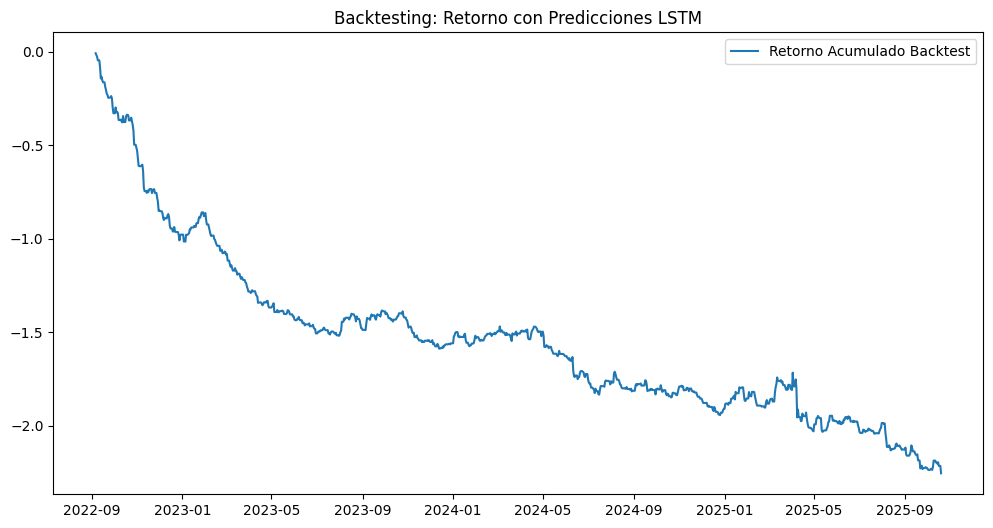

RMSE: 17.527172861813753


In [27]:
# Usando predicciones LSTM como ejemplo
actuals = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
preds = pred_lstm.flatten()

# Señales: 1 buy, -1 sell
signals = np.where(preds > actuals, 1, -1)  # Compara con actual

# Retornos
returns = (ts_data[-len(preds):].pct_change() * signals).cumsum()

plt.figure(figsize=(12,6))
plt.plot(returns, label='Retorno Acumulado Backtest')
plt.legend()
plt.title('Backtesting: Retorno con Predicciones LSTM')
plt.show()

# Métricas
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(actuals, preds))
print('RMSE:', rmse)